# Численные методы

# Определение стоимости автомобилей


## 1. Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель:** Необходимо построить модель для определения стоимости автомобилей на основании технических характеристик, комплектаций других данных. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Признаки**
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **NotRepaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

**Целевой признак**

**Price** — цена (евро)

**План работы:**
1) Загрузить и подготовить данные.
2) Обучить разные модели. Для каждой попробовать различные гиперпараметеры.
3) Выбрать наулилучшую модель по 3 параметрам: качество, скорость и время обучения.

## 2. Подготовка и исследование данных

### 2.1. Загрузка и первичная обработка данных

**Подключаем и устанавливаем библиотеки:**
- **pandas** - для работы с таблицами
- **seaborn**, **matplotlib** - для визуализации данных
- **sklearn** - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных)
- **catboost**, **lightgbm** - специальные регрессоры

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import time
%matplotlib inline

Загрузим данные из файлов, выведем 10 рандомных строк таблицы для визуального анализа.

In [2]:
try:
    datacar = pd.read_csv('autos.csv')
except:
    datacar = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

datacar.info()
datacar.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
172759,2016-03-06 08:36:52,2200,NaN,2005,manual,64,polo,150000,9,NaN,volkswagen,no,2016-03-06 00:00:00,0,15345,2016-04-06 01:16:54
255842,2016-03-19 16:43:57,450,sedan,1994,manual,75,golf,150000,5,petrol,volkswagen,yes,2016-03-19 00:00:00,0,48565,2016-03-19 16:43:57
252970,2016-03-28 19:52:51,12100,sedan,2009,manual,95,one,70000,3,petrol,mini,no,2016-03-28 00:00:00,0,1309,2016-04-07 02:17:49
212725,2016-04-01 17:37:00,4900,small,2007,auto,68,c1,125000,4,petrol,citroen,no,2016-04-01 00:00:00,0,90441,2016-04-05 12:46:07
267449,2016-03-31 15:51:11,7250,convertible,2006,manual,150,astra,100000,10,gasoline,opel,no,2016-03-31 00:00:00,0,31789,2016-04-06 09:44:27
194697,2016-03-28 19:37:19,15600,wagon,2006,auto,435,other,150000,12,petrol,audi,no,2016-03-28 00:00:00,0,99974,2016-04-07 01:45:44
232522,2016-03-31 14:54:57,14000,convertible,1981,manual,126,spider,150000,2,petrol,alfa_romeo,no,2016-03-31 00:00:00,0,58300,2016-04-04 06:53:25
35625,2016-03-14 13:58:38,2700,sedan,2005,NaN,0,c_klasse,150000,6,gasoline,mercedes_benz,no,2016-03-14 00:00:00,0,21376,2016-03-14 13:58:38
210991,2016-03-08 21:37:19,850,small,2001,manual,75,2_reihe,150000,9,petrol,peugeot,NaN,2016-03-08 00:00:00,0,35108,2016-03-10 10:16:13
45581,2016-03-10 11:55:24,6300,coupe,2007,manual,139,c_reihe,150000,10,NaN,volvo,no,2016-03-10 00:00:00,0,74821,2016-03-17 18:17:07


In [3]:
#Столбец NumberOfPictures какой-то однообразный
datacar['NumberOfPictures'].unique()

array([0], dtype=int64)

- В столбце **NumberOfPictures** одно единственное значение, что абсолютно бесполезно для анализа)
- По **PostalCode** потенциально можно определить географически "место приписки" автомобиля а следовательно стоимость транспортировки до дилера, но в исходной задаче нет адреса дилера, поэтому этот столбец не несёт полезной для предсказания цены информации, удалим его. 
- Столбец **DateCrawled** - дата скачивания анкеты не влияет на стоимость автомобиля, а дата создания **DateCreated** вместе с **LastSeen** может сориентировать по времени активности пользователя.
- Столбец **Brand** на первый взгляд избыточен, но он без пропусков поэтому по нему можно составить более точную классификацию. Оставляем)

In [4]:
datacar = datacar.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled'], axis=1)

In [5]:
datacar.duplicated().sum()

103

In [6]:
datacar = datacar.drop_duplicates()

In [7]:
#для удобства целевые признаки поделим на численные и категорийные
numerics = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
categorials =['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [8]:
for category in categorials:
    display(datacar[category].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', nan], dtype=object)

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

array([nan, 'yes', 'no'], dtype=object)

### 2.2. Обработка пропусков
Посмотрим ещё раз на наши пропуски

In [9]:
datacar.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19832
Power                    0
Model                19704
Kilometer                0
RegistrationMonth        0
FuelType             32892
Brand                    0
Repaired             71149
DateCreated              0
LastSeen                 0
dtype: int64

**Repaired** и **Model** заполним неизвестными значениями, а **VehicleType**, **Gearbox**, **FuelType** - наиболее часто встречающимися у данной модели

In [10]:
datacar['Repaired'] = datacar['Repaired'].fillna('unknown')
datacar['Model'] = datacar['Model'].fillna('unknown')

In [11]:
for category in ['VehicleType', 'Gearbox', 'FuelType']:
    datacar[category] = datacar[category].fillna(datacar
                                                 .groupby('Model')[category]
                                                 .transform(lambda x: x.value_counts().idxmax())
                                                 )

In [12]:
print(f'В данных осталось {datacar.isna().sum().sum()} пропусков')

В данных осталось 0 пропусков


Посмотрим распределение по брендам машин в продаже и медианных цен, пробега и мощности.

In [13]:
datacar.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354266.000000,354266.000000,354266.000000,354266.000000,354266.000000
mean,4416.262447,2004.234753,110.088544,128212.571909,5.714421
std,4514.077652,90.240994,189.875204,37905.672706,3.726484
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


После первичного знакомства с нашими данными можно сделать вывод, что:

- В столбце **RegistrationYear** есть аномальные значения, а именно, минимальный год выпуска 1000 год, а максимальный 9999
- В столбце **Power** минимальное значение 0, что говорит о том, что скорее всего автомобиль в разборе и не имеет двигателя (ниже я отбрасываю значения, у первых автомобилей в продаже ~1900 года "регистрации" мощность была примерно 1 л.с.)  на данный момент, а максимальное значение в 20000 л.с. - аномально, на 2016 год автомобили не имели мощность выше 1500 л.с. (источник - ниже)
- В столбце **Price** есть аномальное значение в 0.
- Так же в столбце **RegistrationMonth** есть 0 значение, которое скорее всего говорит о том, что данные не указаны или потеряны
- В столбце **Kilometer** слишком округлённые значения и максимальные значение 150 000 км, учитывая, что в выборке есть автомобили прошлого тысячелетия. Скорее всего при заполнении объявления есть ограничения.

### 2.3. Первичная предобработка.

Для начала посмотрим на нулевые цены и выделим их в отдельный датасет.

In [14]:
display(datacar.query('Price == 0').sample(5))

print('Количество объявлений с нулевой ценой:',
      round(datacar.query('Price == 0').shape[0] / datacar.shape[0] * 100, 2),'%')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,LastSeen
124087,0,small,1992,manual,50,ypsilon,40000,3,petrol,lancia,no,2016-03-28 00:00:00,2016-04-07 02:47:07
184598,0,sedan,9999,manual,0,unknown,10000,0,petrol,sonstige_autos,unknown,2016-03-09 00:00:00,2016-03-13 01:46:23
253974,0,sedan,1998,manual,0,unknown,150000,6,petrol,volkswagen,unknown,2016-03-19 00:00:00,2016-03-20 11:19:44
116672,0,sedan,1991,auto,109,other,150000,5,petrol,mercedes_benz,no,2016-03-20 00:00:00,2016-03-24 09:16:17
286452,0,sedan,1997,manual,150,passat,150000,7,petrol,volkswagen,no,2016-04-05 00:00:00,2016-04-05 11:41:37


Количество объявлений с нулевой ценой: 3.04 %


In [15]:
datacar_zero = datacar.query('Price == 0')
datacar_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10771 entries, 7 to 354364
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Price              10771 non-null  int64 
 1   VehicleType        10771 non-null  object
 2   RegistrationYear   10771 non-null  int64 
 3   Gearbox            10771 non-null  object
 4   Power              10771 non-null  int64 
 5   Model              10771 non-null  object
 6   Kilometer          10771 non-null  int64 
 7   RegistrationMonth  10771 non-null  int64 
 8   FuelType           10771 non-null  object
 9   Brand              10771 non-null  object
 10  Repaired           10771 non-null  object
 11  DateCreated        10771 non-null  object
 12  LastSeen           10771 non-null  object
dtypes: int64(5), object(8)
memory usage: 1.2+ MB


Данные о нулевой цене точно не надо учитывать в моделях, но после обучения моделей можно будет попробовать дополнительно проверить модели и на машинах с нулевой ценой. Выделим машины с нулевой ценой в отдельный датасет, а из исходных данных информацию о машинах с нулевой стоимостью удалим.

In [16]:
datacar.query('RegistrationYear > 2016').shape[0]

14530

Заметное количество объявлений из будущего, на момент составления таблицы))

В очистке данных и формировании чистого датасета учтем следующие соображения:
- Ненулевая стоимость.
- Первый автомобиль был продан в 1898 году, раритетные автомобили могли остаться в продаже, оставим для удобства временные рамки с 1900 года до 2016 года включительно (примеры аномалий позднее 2016 года показаны выше).
- Мощность в лошадиных силах - на 2016 год самая мощная машина имела 1500 л.с. (по запросу 'maximum horsepower for car' в google: Koenigsegg Regera), нулевые значения тоже отбросим
- 5000 km как минимальное значение пробега, и 0 месяц регистрации (кодировка неизвестности) - вполне нормальные значения, поэтому по этим признакам датасет не чистим.

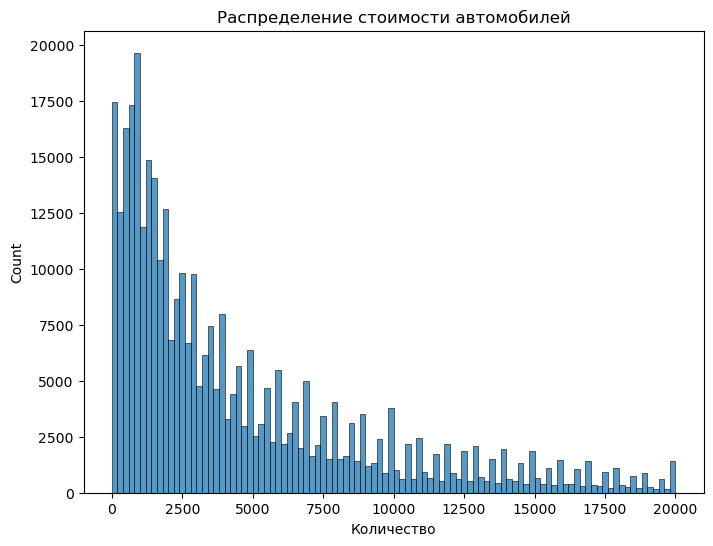

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(data=datacar, x='Price', bins=100)
plt.title('Распределение стоимости автомобилей')
plt.xlabel('Количество')
plt.show()

Много нулевых и округлённых до 500 и 1000 значений и равных 20000. Цены от 0 до 20 могут быть в тыс. евро.

In [18]:
datacar_cleaned = datacar.query('20 < Price < 20000 and 1900 <= RegistrationYear <= 2016 and 0 < Power <= 1500')
print(f'После удаления аномальных данных осталось {round(datacar_cleaned.shape[0] * 100 / datacar.shape[0], 1)}'+ 
      ' % от исходного датасета')

После удаления аномальных данных осталось 83.5 % от исходного датасета


### 2.4. Обработка временных признаков (DateCreated и LastSeen)

In [19]:
null_date = min(datacar_cleaned['DateCreated'])
print('Минимальная дата регистрации объявления:', null_date)

Минимальная дата регистрации объявления: 2015-03-20 00:00:00


Признаки **DateCreated** и **LastSeen** преобразуем в количество дней с 2015-03-20 00:00:00. И создадим столбец **UserActivityDays**, в которм отобразим длительность активности пользователя в днях.

In [20]:
datacar_cleaned['DateCreated'] = datacar_cleaned['DateCreated'].map(
    lambda date: (pd.Timestamp(date) - pd.Timestamp(null_date)).days)
datacar_cleaned['LastSeen'] = datacar_cleaned['LastSeen'].map(
    lambda date: (pd.Timestamp(date) - pd.Timestamp(null_date)).days)
datacar_cleaned['UserActivityDays'] = datacar_cleaned['LastSeen'] - datacar_cleaned['DateCreated']

C:\Users\Asus\AppData\Local\Temp\ipykernel_13216\3511046265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacar_cleaned['DateCreated'] = datacar_cleaned['DateCreated'].map(
C:\Users\Asus\AppData\Local\Temp\ipykernel_13216\3511046265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacar_cleaned['LastSeen'] = datacar_cleaned['LastSeen'].map(
C:\Users\Asus\AppData\Local\Temp\ipykernel_13216\3511046265.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [21]:
datacar_cleaned.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,LastSeen,UserActivityDays
count,295658.000000,295658.000000,295658.000000,295658.000000,295658.000000,295658.000000,295658.000000,295658.000000
mean,4853.100954,2002.818591,120.963380,128295.598293,5.995447,366.804098,375.703664,8.899566
std,4592.710326,6.545174,57.950945,36754.466241,3.582595,9.326408,9.120934,8.597734
min,24.000000,1910.000000,1.000000,5000.000000,0.000000,0.000000,351.000000,0.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,3.000000,359.000000,369.000000,2.000000
50%,3200.000000,2003.000000,110.000000,150000.000000,6.000000,367.000000,381.000000,6.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.000000,375.000000,383.000000,14.000000
max,19999.000000,2016.000000,1500.000000,150000.000000,12.000000,384.000000,384.000000,384.000000


In [22]:
datacar_zero = datacar_zero.query('1900 <= RegistrationYear <= 2016 and 0 < Power <= 1500')
datacar_zero['DateCreated'] = datacar_zero['DateCreated'].map(
    lambda date : (pd.Timestamp(date) - pd.Timestamp(null_date)).days)
datacar_zero['LastSeen'] = datacar_zero['LastSeen'].map(
    lambda date : (pd.Timestamp(date) - pd.Timestamp(null_date)).days)
datacar_zero['UserActivityDays'] = datacar_zero['LastSeen'] - datacar_zero['DateCreated']

In [23]:
datacar_zero.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,LastSeen,UserActivityDays
count,6407.0,6407.000000,6407.000000,6407.000000,6407.000000,6407.000000,6407.000000,6407.000000
mean,0.0,1999.682066,117.312159,132224.910254,4.628843,366.886843,373.974247,7.087404
std,0.0,7.802485,62.931207,39427.211167,4.037859,9.256846,9.631784,7.922027
min,0.0,1910.000000,1.000000,5000.000000,0.000000,312.000000,351.000000,0.000000
25%,0.0,1996.000000,75.000000,150000.000000,0.000000,359.000000,367.000000,1.000000
50%,0.0,1999.000000,105.000000,150000.000000,4.000000,367.000000,377.000000,4.000000
75%,0.0,2003.000000,148.000000,150000.000000,8.000000,375.000000,383.000000,11.000000
max,0.0,2016.000000,1111.000000,150000.000000,12.000000,384.000000,384.000000,59.000000


In [24]:
#для удобства обновим численные и категорийные целевые признаки
numerics = ['RegistrationYear', 'Power', 'Kilometer', 'UserActivityDays']

In [25]:
datacar_cleaned[['Price'] + numerics].corr()

,Price,RegistrationYear,Power,Kilometer,UserActivityDays
Price,1.000000,0.481272,0.466609,-0.386398,0.146964
RegistrationYear,0.481272,1.000000,0.123547,-0.286301,0.033569
Power,0.466609,0.123547,1.000000,0.099598,0.052532
Kilometer,-0.386398,-0.286301,0.099598,1.000000,-0.071573
UserActivityDays,0.146964,0.033569,0.052532,-0.071573,1.000000


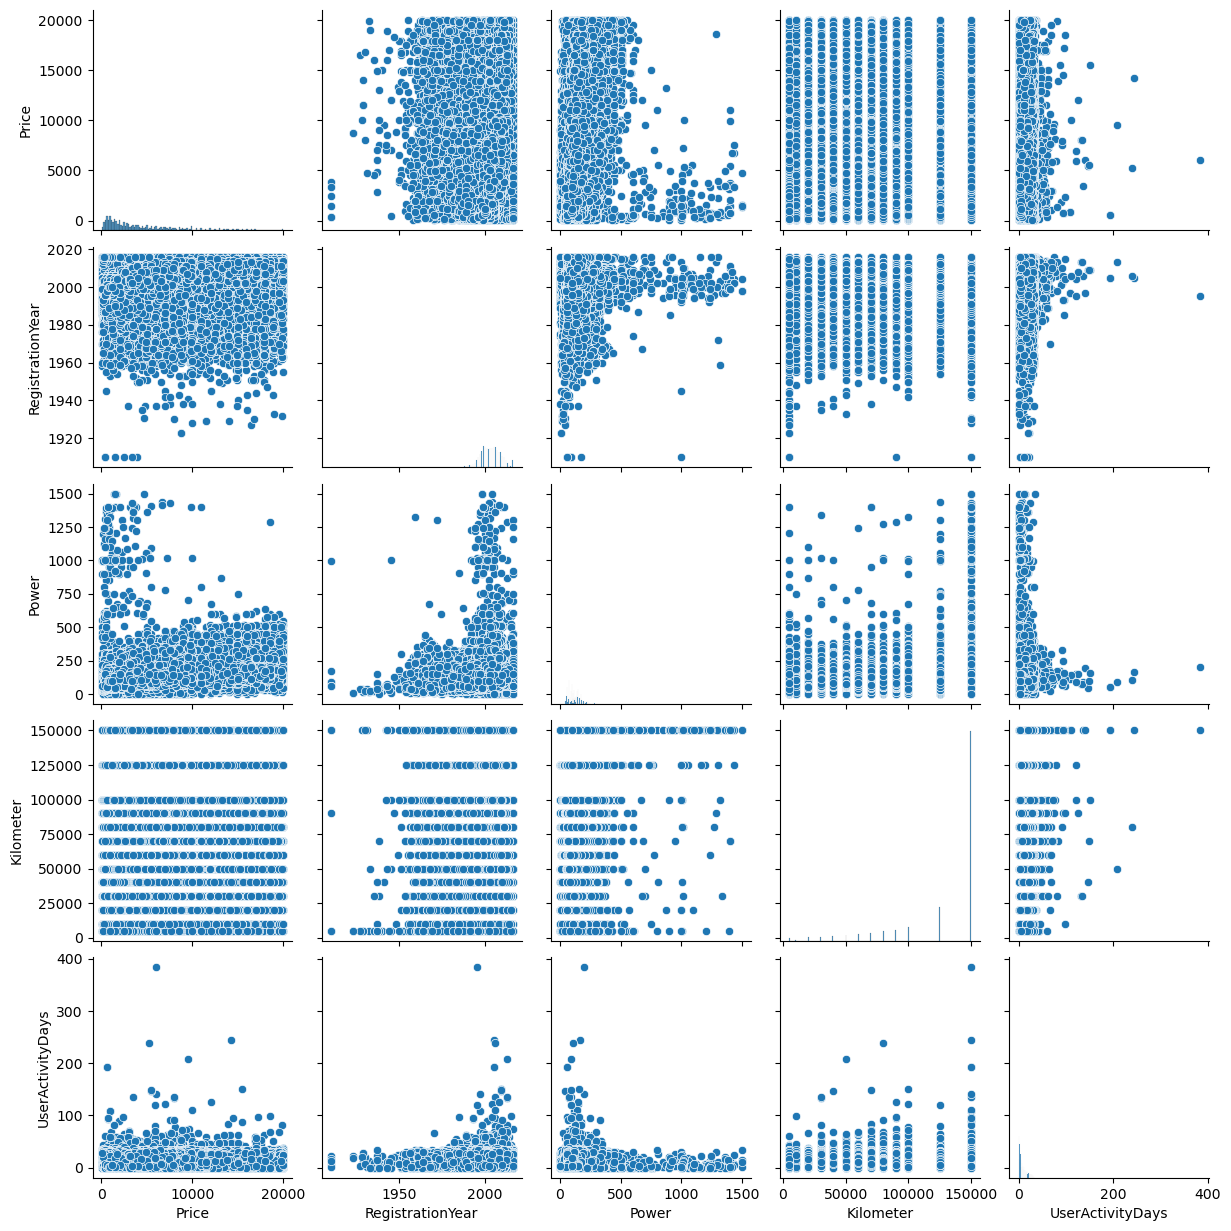

In [26]:
sns.pairplot(datacar_cleaned[['Price'] + numerics]) #визуальное подкрепление, но долгая обработка

In [27]:
datacar_zero[numerics].corr()

,RegistrationYear,Power,Kilometer,UserActivityDays
RegistrationYear,1.000000,0.102303,-0.001958,-0.051833
Power,0.102303,1.000000,-0.019710,0.009792
Kilometer,-0.001958,-0.019710,1.000000,-0.032421
UserActivityDays,-0.051833,0.009792,-0.032421,1.000000


Ни в одном из датасетов признаки не коррелируют между собой, но с ценой корреляция есть

Вывод
- Данные были успешно загружены и проанализированы. 
- Типы данных соответствуют описанию, дубликаты удалены.
- Пропущенные значения, выбросы, а также неправдоподобные значения в признаках по возможности заполнены на основе имеющейся информации. 
- Для построения моделй оставлено около 83% данных.

## 3. Обучение моделей

### 3.1. Подготовка выборок

- Выделим features и целевой признак target. 
- Разделим выборку на обучающую и тестовую в соотношении 1:4.
- Проведем кодировку категориальных признаков
- Проведем масштабирование числовых переменных

**Кодирование категориальных признаков**

В признаке **Model** много категорий, попробуем совместить его с признаком **Brand** 

In [28]:
datacar_cleaned['BrandModel'] = datacar_cleaned['Brand'].astype(str) + ' ' + datacar_cleaned['Model'].astype(str)
datacar_zero['BrandModel'] = datacar_zero['Brand'].astype(str) + ' ' + datacar_zero['Model'].astype(str)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13216\4284011025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacar_cleaned['BrandModel'] = datacar_cleaned['Brand'].astype(str) + ' ' + datacar_cleaned['Model'].astype(str)


In [29]:
features = datacar_cleaned.drop('Price', axis=1)
target = datacar_cleaned['Price']

features_zero = datacar_zero.drop('Price', axis=1)
target_zero = datacar_zero['Price']

RANDOM_STATE, CV = 12345, 5

In [30]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE)
   
print(f"Размер обучающей выборки: {features_train.shape}")                 
print(f"Размер тестовой выборки: {features_test.shape}")
print(f"Размер выборки пропущенных значений цены: {features_zero.shape}")

Размер обучающей выборки: (236526, 14)
Размер тестовой выборки: (59132, 14)
Размер выборки пропущенных значений цены: (6407, 14)


In [31]:
categorials = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'BrandModel', 'RegistrationMonth']
print('Число моделей в выбоpке: ', len(features_train['BrandModel'].unique()))
print('')
for category in categorials:
    print('Соотношение признаков в категории ' + category)
    display(datacar_cleaned[category].value_counts(normalize=True))

Число моделей в выбоpке:  335

Соотношение признаков в категории VehicleType


sedan          0.301233
small          0.245246
wagon          0.203340
bus            0.091322
convertible    0.063644
coupe          0.049500
suv            0.037296
other          0.008419
Name: VehicleType, dtype: float64

Соотношение признаков в категории Gearbox


manual    0.79868
auto      0.20132
Name: Gearbox, dtype: float64

Соотношение признаков в категории FuelType


petrol      0.676931
gasoline    0.304402
lpg         0.015802
cng         0.001627
hybrid      0.000676
other       0.000308
electric    0.000254
Name: FuelType, dtype: float64

Соотношение признаков в категории Repaired


no         0.758214
unknown    0.144532
yes        0.097254
Name: Repaired, dtype: float64

Соотношение признаков в категории BrandModel


volkswagen golf                  0.083387
bmw 3er                          0.058591
volkswagen polo                  0.036099
opel corsa                       0.034141
opel astra                       0.030654
                                   ...   
rover discovery                  0.000007
land_rover range_rover_evoque    0.000007
rover rangerover                 0.000007
rover freelander                 0.000003
rover defender                   0.000003
Name: BrandModel, Length: 336, dtype: float64

Соотношение признаков в категории RegistrationMonth


3     0.102818
6     0.093138
4     0.087013
5     0.086607
7     0.080529
10    0.077596
12    0.071674
11    0.071018
9     0.070818
1     0.068224
8     0.066651
2     0.063665
0     0.060249
Name: RegistrationMonth, dtype: float64

Остальные категориальные признаки закодируем **OneHotEncoder**:

Масштабируем числовые признаки **StandardScaler**:

In [32]:
scaler = StandardScaler()

scaler.fit(features_train[numerics])
features_train[numerics] = scaler.transform(features_train[numerics])
features_test[numerics] = scaler.transform(features_test[numerics])

features_zero[numerics] = scaler.fit_transform(features_zero[numerics])
pd.options.mode.chained_assignment = None

Соберем из числовых, кодированных категориальных признаков и **'RegistrationMonth'** новые **features**.

In [33]:
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

ohe_encoder.fit(features_train[categorials])

features_train_encoded = pd.DataFrame(
      ohe_encoder.transform(features_train[categorials]).toarray(),
      columns=ohe_encoder.get_feature_names_out(categorials),
      index=features_train.index)

features_test_encoded = pd.DataFrame(
      ohe_encoder.transform(features_test[categorials]).toarray(),
      columns=ohe_encoder.get_feature_names_out(categorials),
      index=features_test.index)

features_zero_encoded = pd.DataFrame(
      ohe_encoder.transform(features_zero[categorials]).toarray(),
      columns=ohe_encoder.get_feature_names_out(categorials),
      index=features_zero.index)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [34]:
features_train_ohe = pd.concat((features_train[numerics], features_train_encoded), axis=1)

features_test_ohe = pd.concat((features_test[numerics], features_test_encoded), axis=1)

features_zero_ohe = pd.concat((features_zero[numerics], features_zero_encoded), axis=1)

In [35]:
print('After OneHotEncoding')
print(f"Размер обучающей выборки: {features_train_ohe.shape}")
print(f"Размер тестовой  выборки: {features_test_ohe.shape}")
print(f"Размер выборки пропущенных значений цены: {features_zero_ohe.shape}")

After OneHotEncoding
Размер обучающей выборки: (236526, 366)
Размер тестовой  выборки: (59132, 366)
Размер выборки пропущенных значений цены: (6407, 366)


<div class="alert alert-block alert-info">
<b>Комментарий студента v2:</b> Решил номер месяца тоже поместить в категориальные признаки.
</div>

In [36]:
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

ord_encoder.fit(features_train[categorials])

features_train_encoded = pd.DataFrame(
      ord_encoder.transform(features_train[categorials]),
      columns=ord_encoder.get_feature_names_out(categorials),
      index=features_train.index)

features_test_encoded = pd.DataFrame(
      ord_encoder.transform(features_test[categorials]),
      columns=ord_encoder.get_feature_names_out(categorials),
      index=features_test.index)

features_zero_encoded = pd.DataFrame(
      ord_encoder.transform(features_zero[categorials]),
      columns=ord_encoder.get_feature_names_out(categorials),
      index=features_zero.index)

In [37]:
features_train_ord = pd.concat((features_train[numerics], features_train_encoded), axis=1)

features_test_ord = pd.concat((features_test[numerics], features_test_encoded), axis=1)

features_zero_ord = pd.concat((features_zero[numerics], features_zero_encoded), axis=1)

In [38]:
print('After OrdinalEncoding')
print(f"Размер обучающей выборки: {features_train_ord.shape}")
print(f"Размер тестовой  выборки: {features_test_ord.shape}")
print(f"Размер выборки пропущенных значений цены: {features_zero_ord.shape}")

After OrdinalEncoding
Размер обучающей выборки: (236526, 10)
Размер тестовой  выборки: (59132, 10)
Размер выборки пропущенных значений цены: (6407, 10)


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Перенёс масштабирование числовых данных перед кодированием категориальных данных. Сделал отдельно две кодировки одной функцией.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Можно ли одной функцией (аналог describe) посмотреть корреляцию между закодированными категориальными признаками.
</div>

Проверим размеры **features**

Для начала создадим константную base-line модель. Она всегда будет предсказывать среднее значение Price. (среднее значение на практике дало меньшее значение RMSE, чем медианное). Рассчитаем RMSE для base-line модели.

In [39]:
def model_results(model, parameters, x_train):
    
    gscv = GridSearchCV(model, param_grid=parameters, cv=CV,
                        scoring='neg_root_mean_squared_error', n_jobs=-1)
    gscv.fit(x_train, target_train)
    
    start = time.time()
    gscv.best_estimator_.fit(x_train, target_train)
    fit_time = (time.time() - start)*1000
      
    start = time.time()
    prediction = gscv.best_estimator_.predict(x_train)
    predict_time = (time.time() - start)*1000
    
    print(f'Гиперпараметры модели {model} с наилучшим rmse:')
    print(gscv.best_params_)
    rmse = -int(gscv.best_score_)
    print('RMSE лучшей модели GridSearchCV:', rmse)
        
    return gscv, fit_time, predict_time, rmse

### 3.2. Обучим константную модель

In [40]:
model_dr = DummyRegressor()
model_dr.get_params().keys()

dict_keys(['constant', 'quantile', 'strategy'])

In [41]:
%%time
dr_parameters = {'strategy': ['mean', 'median']}
dr_gscv, dr_fit_time, dr_predict_time, dr_rmse = model_results(model_dr, dr_parameters,
                                                               features_train)

dummy_regressor = [dr_gscv, dr_fit_time, dr_predict_time, dr_rmse]

Гиперпараметры модели DummyRegressor() с наилучшим rmse:
{'strategy': 'mean'}
RMSE лучшей модели GridSearchCV: 4589
CPU times: total: 3.75 s
Wall time: 13.8 s


RMSE константной модели - 4589, что сильно болльше Т.З. (2500)

Далее в каждой модели будем варьировать 8 значений 2-4 гиперпараметров одного рода для адкеватной оценки скорости рассчёта моделей 

### 3.3. Линейные регрессии

**Линейная регрессия без регуляризации**

Сначала обучим линейную модель. Посчитаем скорость обучения, скорость предсказания и RMSE модели. Обучение будем проводить с использованием кросс-валидации на 5 фолдов.

In [42]:
model_lr = LinearRegression(copy_X=True)
model_lr.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'positive'])

In [43]:
%%time
lr_parameters = {#'copy_X': [True, False],
                 'fit_intercept': [True, False],
                 'positive': [True, False]
                }

lr_gscv, lr_fit_time, lr_predict_time, lr_rmse_train = model_results(model_lr, lr_parameters,
                                                                     features_train_ohe)

Гиперпараметры модели LinearRegression() с наилучшим rmse:
{'fit_intercept': True, 'positive': False}
RMSE лучшей модели GridSearchCV: 2645
CPU times: total: 1min 2s
Wall time: 22min 19s


In [44]:
linear_regressor = [lr_gscv, lr_fit_time, lr_predict_time, lr_rmse_train]

**Lasso/Ridge**

Попробуем обучить линейные модели с регуляризацией L1 и L2.

In [45]:
model_lasso = Lasso(random_state=RANDOM_STATE, fit_intercept=True, positive=False)
model_lasso.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [46]:
%%time
lasso_parameters = {'alpha': [0.01, 0.02, 0.05, 0.1],
                    'max_iter': [10, 20],
                    }

lasso_gscv, lasso_fit_time, lasso_predict_time, lasso_rmse = model_results(model_lasso, lasso_parameters, 
                                                                           features_train_ohe)

lasso_regressor = [lasso_gscv, lasso_fit_time, lasso_predict_time, lasso_rmse]

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.630e+11, tolerance: 4.983e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.630e+11, tolerance: 4.983e+08
  model = cd_fast.enet_coordinate_descent(


Гиперпараметры модели Lasso(random_state=12345) с наилучшим rmse:
{'alpha': 0.02, 'max_iter': 20}
RMSE лучшей модели GridSearchCV: 2645
CPU times: total: 37.8 s
Wall time: 10min 57s


In [47]:
model_ridge = Ridge(random_state=RANDOM_STATE, fit_intercept=True, positive=False)
model_ridge.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'positive', 'random_state', 'solver', 'tol'])

In [48]:
%%time
ridge_parameters = {'alpha': [0.01, 0.02, 0.05, 0.1],
                    'max_iter': [10, 20],
                    }

ridge_gscv, ridge_fit_time, ridge_predict_time, ridge_rmse = model_results(model_ridge, ridge_parameters,
                                                                           features_train_ohe)

ridge_regressor = [ridge_gscv, ridge_fit_time, ridge_predict_time, ridge_rmse]

Гиперпараметры модели Ridge(random_state=12345) с наилучшим rmse:
{'alpha': 0.1, 'max_iter': 10}
RMSE лучшей модели GridSearchCV: 2645
CPU times: total: 20.3 s
Wall time: 6min 39s


### 3.3. Регрессоры DecisionTree и RandomForest

**DecisionTreeRegressor**

In [49]:
dtr_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
dtr_model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [50]:
%%time
dtr_parameters = {'max_depth': range (5, 21, 5),
                  'min_samples_split': [5, 10]}

dt_gscv, dt_fit_time, dt_predict_time, dt_rmse = model_results(dtr_model, dtr_parameters,
                                                               features_train_ord)

dt_regressor = [dt_gscv, dt_fit_time, dt_predict_time, dt_rmse]

Гиперпараметры модели DecisionTreeRegressor(random_state=12345) с наилучшим rmse:
{'max_depth': 15, 'min_samples_split': 10}
RMSE лучшей модели GridSearchCV: 1852
CPU times: total: 4.7 s
Wall time: 44.9 s


**RandomForestRegressor**

In [51]:
rfr_model = RandomForestRegressor(random_state=RANDOM_STATE)
rfr_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [52]:
%%time
rfr_parameters = {'n_estimators': [10, 20],
                  'max_depth': [10, 20],
                  'min_samples_split': [5, 10]}

rf_gscv, rf_fit_time, rf_predict_time, rf_rmse = model_results(rfr_model, rfr_parameters,
                                                               features_train_ord)

rf_regressor = [rf_gscv, rf_fit_time, rf_predict_time, rf_rmse]

Гиперпараметры модели RandomForestRegressor(random_state=12345) с наилучшим rmse:
{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 20}
RMSE лучшей модели GridSearchCV: 1573
CPU times: total: 1min 20s
Wall time: 8min 3s


### 3.4. Модели с градиентными бустигами: GradientBoostingRegressor, LightGBM и CatBoost

**GradientBoostingRegressor**

In [53]:
gbr_model = GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=20)
gbr_model.get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [54]:
%%time
gbr_parameters = {'max_depth': [10, 20],
                  'min_samples_split': [5, 10],
                  'learning_rate': [0.1, 0.2]}

gb_gscv, gb_fit_time, gb_predict_time, gb_rmse = model_results(gbr_model, gbr_parameters,
                                                               features_train_ord)

gb_regressor = [gb_gscv, gb_fit_time, gb_predict_time, gb_rmse]

Гиперпараметры модели GradientBoostingRegressor(n_estimators=20, random_state=12345) с наилучшим rmse:
{'learning_rate': 0.2, 'max_depth': 10, 'min_samples_split': 5}
RMSE лучшей модели GridSearchCV: 1576
CPU times: total: 1min 2s
Wall time: 15min 8s


**LGBMRegressor**

In [55]:
lgbmr_model = LGBMRegressor(random_state=RANDOM_STATE)
lgbmr_model.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [56]:
%%time
lgbmr_parameters = {'n_estimators': [20, 50],
                    'max_depth': [10, 20],
                    'learning_rate': [0.1, 0.2]}

lgbm_gscv, lgbm_fit_time, lgbm_predict_time, lgbm_rmse = model_results(lgbmr_model, lgbmr_parameters,
                                                                       features_train_ord)

lgbm_regressor = [lgbm_gscv, lgbm_fit_time, lgbm_predict_time, lgbm_rmse]

Гиперпараметры модели LGBMRegressor(random_state=12345) с наилучшим rmse:
{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50}
RMSE лучшей модели GridSearchCV: 1647
CPU times: total: 8.41 s
Wall time: 1min


**CatBoostRegressor**

In [57]:
cbtr_model = CatBoostRegressor(random_state=RANDOM_STATE)
cbtr_model.get_params().keys()

dict_keys(['loss_function', 'random_state'])

In [58]:
cbtr_parameters = {'learning_rate': [0.1, 0.2],
                   'iterations': [20, 50],
                   'max_depth': [10, 20]}

cbt_gscv, cbt_fit_time, cbt_predict_time, cbt_rmse = model_results(cbtr_model, cbtr_parameters, 
                                                                   features_train_ord)

cbt_regressor = [cbt_gscv, cbt_fit_time, cbt_predict_time, cbt_rmse]

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Asus\anaconda3\lib\site-packages\catboost\core.py", line 5734, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\Asus\anaconda3\lib\site-packages\catboost\core.py", line 2341, in _fit
    tr

0:	learn: 3953.8413156	total: 317ms	remaining: 15.6s
1:	learn: 3453.1524409	total: 479ms	remaining: 11.5s
2:	learn: 3074.2181854	total: 665ms	remaining: 10.4s
3:	learn: 2782.3309689	total: 827ms	remaining: 9.51s
4:	learn: 2547.3656578	total: 1.03s	remaining: 9.27s
5:	learn: 2373.8960971	total: 1.19s	remaining: 8.76s
6:	learn: 2243.2907469	total: 1.43s	remaining: 8.77s
7:	learn: 2137.7680770	total: 1.62s	remaining: 8.52s
8:	learn: 2066.6373146	total: 1.79s	remaining: 8.15s
9:	learn: 2006.3130311	total: 2.04s	remaining: 8.16s
10:	learn: 1956.4722565	total: 2.2s	remaining: 7.8s
11:	learn: 1919.9468311	total: 2.37s	remaining: 7.52s
12:	learn: 1889.9100939	total: 2.54s	remaining: 7.24s
13:	learn: 1857.9701676	total: 2.77s	remaining: 7.11s
14:	learn: 1834.5785121	total: 2.96s	remaining: 6.91s
15:	learn: 1818.3236698	total: 3.17s	remaining: 6.74s
16:	learn: 1801.4702654	total: 3.37s	remaining: 6.54s
17:	learn: 1782.2891820	total: 3.56s	remaining: 6.33s
18:	learn: 1769.1285587	total: 3.73s	rem

### 3.5 Общий анализ моделей
Все обученные модели смогли улучшить RMSE базовой модели.

In [59]:
Models = pd.DataFrame([linear_regressor[1:], lasso_regressor[1:], ridge_regressor[1:], dt_regressor[1:], 
                      rf_regressor[1:], gb_regressor[1:], lgbm_regressor[1:], cbt_regressor[1:]], 
                      columns=['Время обучения (мc)', 'Время предсказания (мc)', 'RMSE'], 
                      index=[f'Linear {linear_regressor[0].best_params_}', f'Lasso {lasso_regressor[0].best_params_}',
                             f'Ridge {ridge_regressor[0].best_params_}', f'DecisionTree {dt_regressor[0].best_params_}',
                             f'RandomForest {rf_regressor[0].best_params_}', f'GradientBoosting {gb_regressor[0].best_params_}',
                             f'LGBM {lgbm_regressor[0].best_params_}', f'CatBoost {cbt_regressor[0].best_params_}'])
Models

,Время обучения (мc),Время предсказания (мc),RMSE
"Linear {'fit_intercept': True, 'positive': False}",20818.905115,1106.155872,2645
"Lasso {'alpha': 0.02, 'max_iter': 20}",10685.423851,311.810732,2645
"Ridge {'alpha': 0.1, 'max_iter': 10}",4801.047087,283.824921,2645
"DecisionTree {'max_depth': 15, 'min_samples_split': 10}",1867.015839,102.935314,1852
"RandomForest {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 20}",39941.427231,2991.151333,1573
"GradientBoosting {'learning_rate': 0.2, 'max_depth': 10, 'min_samples_split': 5}",30792.058468,845.762253,1576
"LGBM {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50}",3160.054207,1301.198959,1647
"CatBoost {'iterations': 50, 'learning_rate': 0.2, 'max_depth': 10}",9809.962749,240.852356,1653


С помощью двух лучших по времени и RMSE регрессоров (**LGBM и CatBoost**) восстановим значения цены для субсета с нулевой стоимостью автомобилей и сравним предсказания.

In [60]:
prediction_zero_lgbm = lgbm_regressor[0].predict(features_zero_ord)
prediction_zero_cbt = cbt_regressor[0].predict(features_zero_ord)

prediction_zero_lgbm = pd.Series(np.ceil(prediction_zero_lgbm), name='LGBM PricePredicted')
prediction_zero_cbt = pd.Series(np.ceil(prediction_zero_cbt), name='CatBoost PricePredicted')

datacar_zero_new = datacar_zero.reset_index()
full_zero = pd.concat((prediction_zero_lgbm, prediction_zero_cbt, 
                       datacar_zero_new.drop(['index', 'Price', 'Brand', 'Model',
                                              'DateCreated', 'LastSeen'], axis=1)), axis=1)
full_zero.sample(10)

,LGBM PricePredicted,CatBoost PricePredicted,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Repaired,UserActivityDays,BrandModel
5653,15243.0,16072.0,wagon,2008,auto,299,150000,11,petrol,no,7,volkswagen passat
3204,1719.0,1589.0,small,1999,manual,54,125000,6,petrol,no,7,opel corsa
46,4775.0,4759.0,sedan,2000,auto,193,150000,5,petrol,unknown,1,bmw 5er
5641,3839.0,3515.0,bus,1994,manual,60,150000,12,gasoline,no,6,volkswagen transporter
6082,3981.0,3487.0,wagon,2016,manual,125,150000,3,petrol,no,10,audi a4
4058,3705.0,3932.0,sedan,1999,manual,165,150000,10,petrol,unknown,12,audi unknown
3155,1795.0,1516.0,small,2002,manual,60,80000,0,petrol,yes,10,ford ka
1328,2571.0,2617.0,sedan,1997,manual,136,100000,7,petrol,no,2,opel vectra
673,2149.0,2385.0,wagon,1999,manual,118,150000,10,petrol,yes,11,bmw unknown
4804,2403.0,2097.0,sedan,1994,manual,90,125000,5,petrol,no,26,audi unknown


Добавил для сравнения предсказание CatBoost как серебряного призёра.

In [61]:
lgbm_prediction = lgbm_regressor[0].predict(features_test_ord)
cbt_prediction = cbt_regressor[0].predict(features_test_ord)

lgbm_rmse_test = int(mse(target_test, lgbm_prediction)**0.5)
print('RMSE модели LGBM на тестовой выборке:', lgbm_rmse_test)
cbt_rmse_test = int(mse(target_test, cbt_prediction)**0.5)
print('RMSE модели CatBoost на тестовой выборке:', cbt_rmse_test)

RMSE модели LGBM на тестовой выборке: 1671
RMSE модели CatBoost на тестовой выборке: 1666


**Выводы по моделям:**
- У моделей варьировались одинаковое число гиперпараметров (8), при переходе к более сложным/регулиремым моделям фиксировались гиперпараметры, полученные на более простых/нерегулируемых моделях.
- RMSE константной модели - 4625, сильно больше ТЗ.
- Линейный регрессор без регуляризации для данной задачи показал себя на уровне с регуляризируемыми Lasso и Ridge: **LinearModel/Lasso/Ridge: 2965/2965/2965**. У всех RMSE не удовлетворяет ТЗ.
- Регрессор **DecisionTree** за относительно короткое время (CPU times: total: 3.38 s) получил хороший по RMSЕ (**1833**) результат.
- У регрессоров **Random Forest и GradientBoosting** хоть и самые хорошие показатели по RMSE (**1578 и 1590**), но время выполнения на порядки выше линейных регрессий и **DecisionTree** (CPU times: total: 47.2/39.1 с vs 3.38)
- У регрессора **LightGBM** скорость обучения в два раза больше скорости обучения **CatBoost**, но скорость предсказания быстрая, но в три раза медленнее **CatBoost**.

## 4. Общий вывод

1) Из данных по продажам авто, удалены лишние и однообразные признаки
2) Произведена предобработка данных: - заполнены пропуски либо неизвестным либо самыми распространёнными в категориях значениями
3) Для обучения моделей было удалено примерно 1/6 данных, содержащих аномальные значения.
4) Исходные данные разделены на обучающую тестовую выборки в соотношении 4:1.
5) Отобраны признаки для регрессиий. Категориальные закодированы **OrdinalEncoder** и **OneHotEncoder**, а числовые - приведены к единой шкале.
6) Исследовано 8 моделей, из которых 3 - динейные, модели проверены на адекватность с помощью константного регрессора **Dummy**
7) По соотношению качества предсказания и времени обучения, а также по удобству пользования у **LGBM** - лучшие показатели. 
8) Если брать в учёт время предсказания то задачами справились **DecisionTree** и **CatBoost**, у последнего точность на уровне **LGBM**
9) С помощью LGBM и CatBoost заполнили 6300 из 10700 позиций с нулевой ценой и сравнили предсказания в одной таблице, а также определили RMSE на тестовой выборке.